In [1]:
import json
import os
import operator
import re
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
base_path = '../../data/annot_pilot'
fig_path = '../figures_pilot'
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
with open(os.path.join(base_path, 'full_annot.json')) as f:
    text_segments = json.load(f)

In [3]:
# calculate some basic stats

# over all
entity_counts_total = dict()
for typ in ['a', 'p', 'v']:
    entity_counts_total[typ] = defaultdict(int)
annotation_type_lengths = defaultdict(list)
annotation_dists = defaultdict(list)
# per context
context_lengths = []
annotation_type_counts_per_context = defaultdict(list)


def relation_tuple_distance(e_dict, rel_tup):
    """ Given an entity dictionary (id to entity)
        and a relation tuple (entity_id, entity_id)
        return the distance in number of characters.
    """
    
    tail_offset = e_dict[rel_tup[0]]['offset']
    head_offset = e_dict[rel_tup[1]]['offset']
    if tail_offset[0] < head_offset[0]:
        # [0]property[1] ---> [0] entity [1]
        # [0] value  [1] ---> [0]property[1]
        #             |         |
        dist = tail_offset[1] - head_offset[0]
        # -> negative value
        # for e.g.
        # - the beta1 of Adam is set to ...
        # - we use 0.001 for the learning rate of ...
    else:
        # [0] entity [1] <--- [0]property[1]
        # [0]property[1] <--- [0] value  [1]
        #             |        |
        #             +--------|---+
        #               +------+   |
        #               |          |
        dist = tail_offset[0] - head_offset[1]
        # -> positive value
        # for e.g.
        # - for Adam we set beta1 to ...
        # - we set beta1 to 0.9
    return dist


def annot_distances(annot):
    """ Return distances between
            entities -> properties
        and
            properties -> values
    """
    
    rel_tpls = annot['relation_tuples']
    e_dict = annot['entity_dict']
    dists = {
        'ap': [],
        'pv': [],
        'apv': []
    }
    # single hops (e<-p / p<-v)
    for rt in rel_tpls:
        tail_type = e_dict[rt[0]]['type']
        head_type = e_dict[rt[1]]['type']
        key = head_type+tail_type
        if key in ['ap', 'pv']:
            dist = relation_tuple_distance(e_dict, rt)
            dists[key].append(dist)
    # douple hops (e<-p<-v)
    for rt1 in rel_tpls:
        for rt2 in rel_tpls:
            if rt1[1] == rt2[0]:
                e_val = e_dict[rt1[0]]
                e_prop = e_dict[rt1[1]]
                e_ent = e_dict[rt2[1]]
                key = e_ent['type']+e_prop['type']+e_val['type']
                if key == 'apv':
                    # ent to prop
                    dist1 = relation_tuple_distance(e_dict, rt2)
                    # prop to val
                    dist2 = relation_tuple_distance(e_dict, rt1)
                    dists['apv'].append(
                        (dist1, dist2)
                    )
    return dists


for txt_seg in text_segments:
    context_lengths.append(len(txt_seg['context']))
    for typ in ['a', 'p', 'v']:
        annots = [
            e for e in txt_seg['annotation']['entity_dict'].values()
            if e['type'] == typ
        ]
        annotation_type_counts_per_context[typ].append(
            len(annots)
        )
    for e in txt_seg['annotation']['entity_dict'].values():
        entity_counts_total[e['type']][e['surface_text']] += 1
        annotation_type_lengths[e['type']].append(len(e['surface_text']))
    dists = annot_distances(txt_seg['annotation'])
    for k, v in dists.items():
        annotation_dists[k].extend(v)

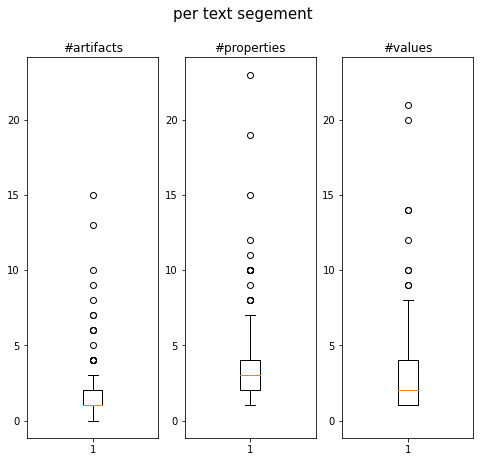

In [4]:
# plot text span stats

# print(stats.describe(context_lengths))
# fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(12, 7))
fig = plt.figure(figsize=(8, 7))
fig.suptitle('per text segement', fontsize=15)
# ax1 = fig.add_subplot(141) 
# ax1.set_title('length (#chars)')
# ax1.boxplot(context_lengths)
ax2 = fig.add_subplot(131)
ax2.set_title('#artifacts')
ax2.boxplot(annotation_type_counts_per_context['a'])
ax3 = fig.add_subplot(132, sharey=ax2) 
ax3.set_title('#properties')
ax3.boxplot(annotation_type_counts_per_context['p'])
ax4 = fig.add_subplot(133, sharey=ax2) 
ax4.set_title('#values')
ax4.boxplot(annotation_type_counts_per_context['v'])
plt.savefig(
    os.path.join(fig_path, 'stats_per_text_span.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

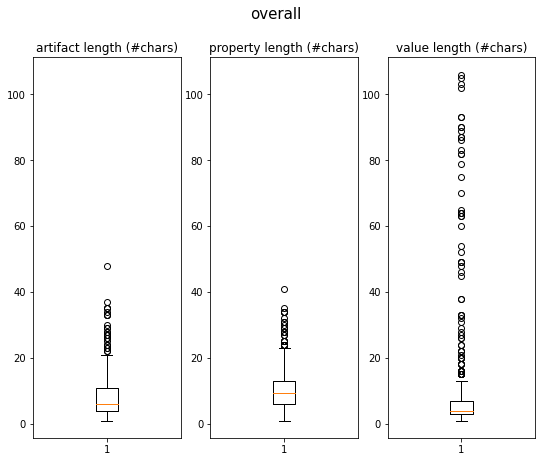

In [5]:
# plot overall annotation type char len statssorted(x.items(), key=operator.itemgetter(1))

fig = plt.figure(figsize=(9, 7))
fig.suptitle('overall', fontsize=15)
ax1 = fig.add_subplot(131) 
ax1.set_title('artifact length (#chars)')
ax1.boxplot(annotation_type_lengths['a'])
ax2 = fig.add_subplot(132, sharey=ax1) 
ax2.set_title('property length (#chars)')
ax2.boxplot(annotation_type_lengths['p'])
ax3 = fig.add_subplot(133, sharey=ax1) 
ax3.set_title('value length (#chars)')
ax3.boxplot(annotation_type_lengths['v'])
plt.savefig(
    os.path.join(fig_path, 'stats_overall.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

In [6]:
# canonicalize frequent yet variably rendered entity names 

entity_counts_total_canon = dict()
entity_counts_total_canon['a'] = defaultdict(int)
nnt_canon_mapping = {
    'adam': 'adam',
    'adaptive moment estimation': 'adam',
    'sgd': 'sgd',
    'gradient descent': 'sgd',
    'stochastic gradient descent': 'sgd',
}
out_of_scope = ['algorithm']
for k, v in entity_counts_total['a'].items():
    kl = k.lower().strip()
    if kl in out_of_scope:
        continue
    if kl in nnt_canon_mapping:
        entity_counts_total_canon['a'][nnt_canon_mapping[kl]] += v
    else:
        entity_counts_total_canon['a'][kl] = v

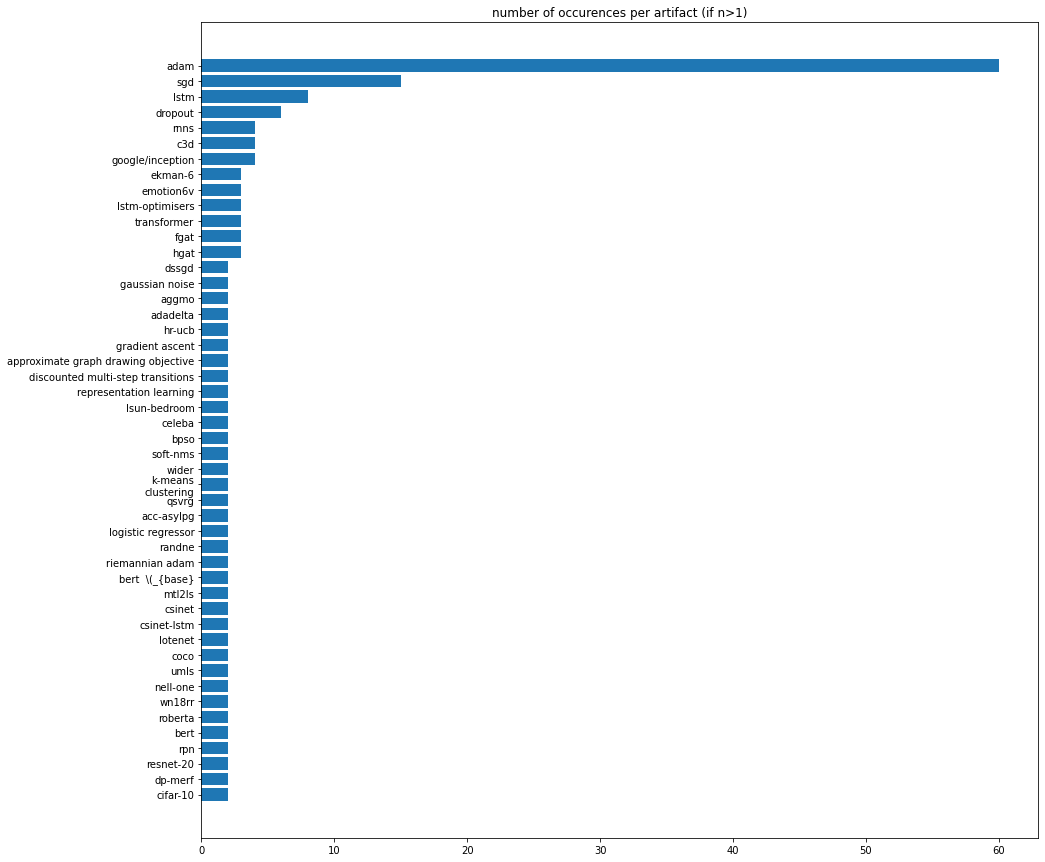

In [7]:
ecounts = sorted(entity_counts_total_canon['a'].items(), key=operator.itemgetter(1))
fig, ax = plt.subplots(figsize=(15,15))
ax.barh(
    [e[0] for e in ecounts if e[1] > 1],
    [e[1] for e in ecounts if e[1] > 1]
)
ax.set_title('number of occurences per artifact (if n>1)')
plt.savefig(
    os.path.join(fig_path, 'stats_artifact_counts.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

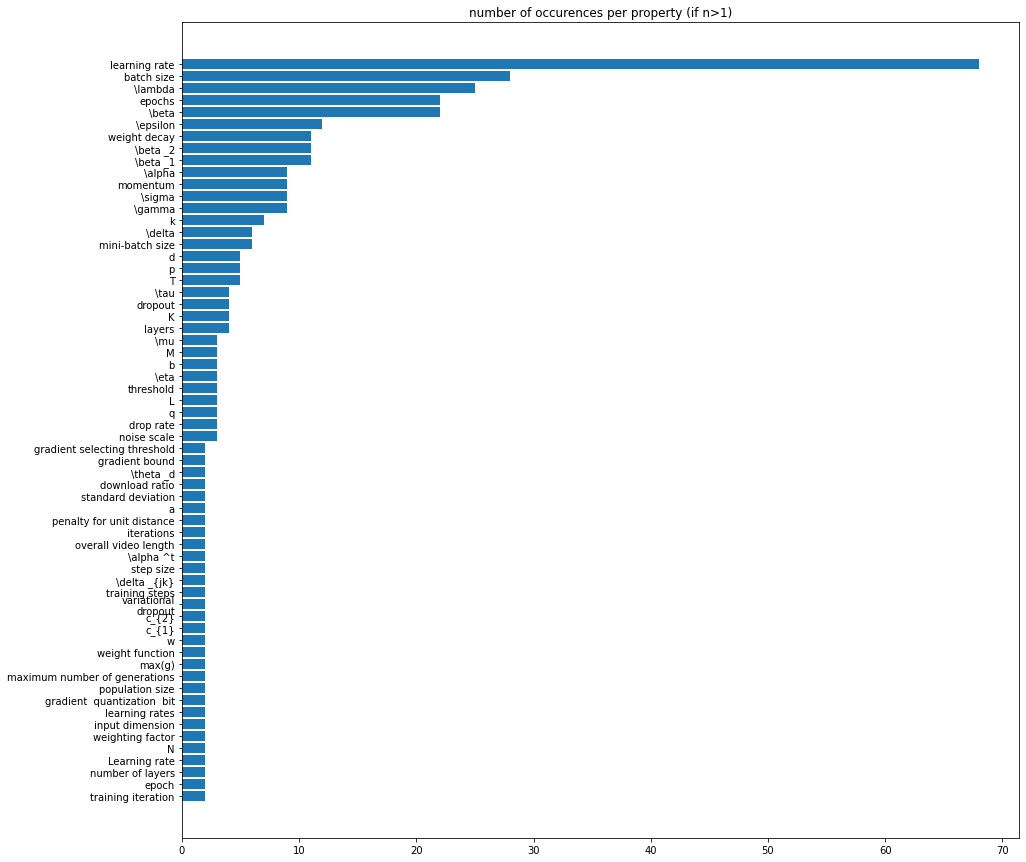

In [8]:
pcounts = sorted(entity_counts_total['p'].items(), key=operator.itemgetter(1))
fig, ax = plt.subplots(figsize=(15,15))
ax.barh(
    [e[0] for e in pcounts if e[1] > 1],
    [e[1] for e in pcounts if e[1] > 1]
)
ax.set_title('number of occurences per property (if n>1)')
plt.savefig(
    os.path.join(fig_path, 'stats_property_counts.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

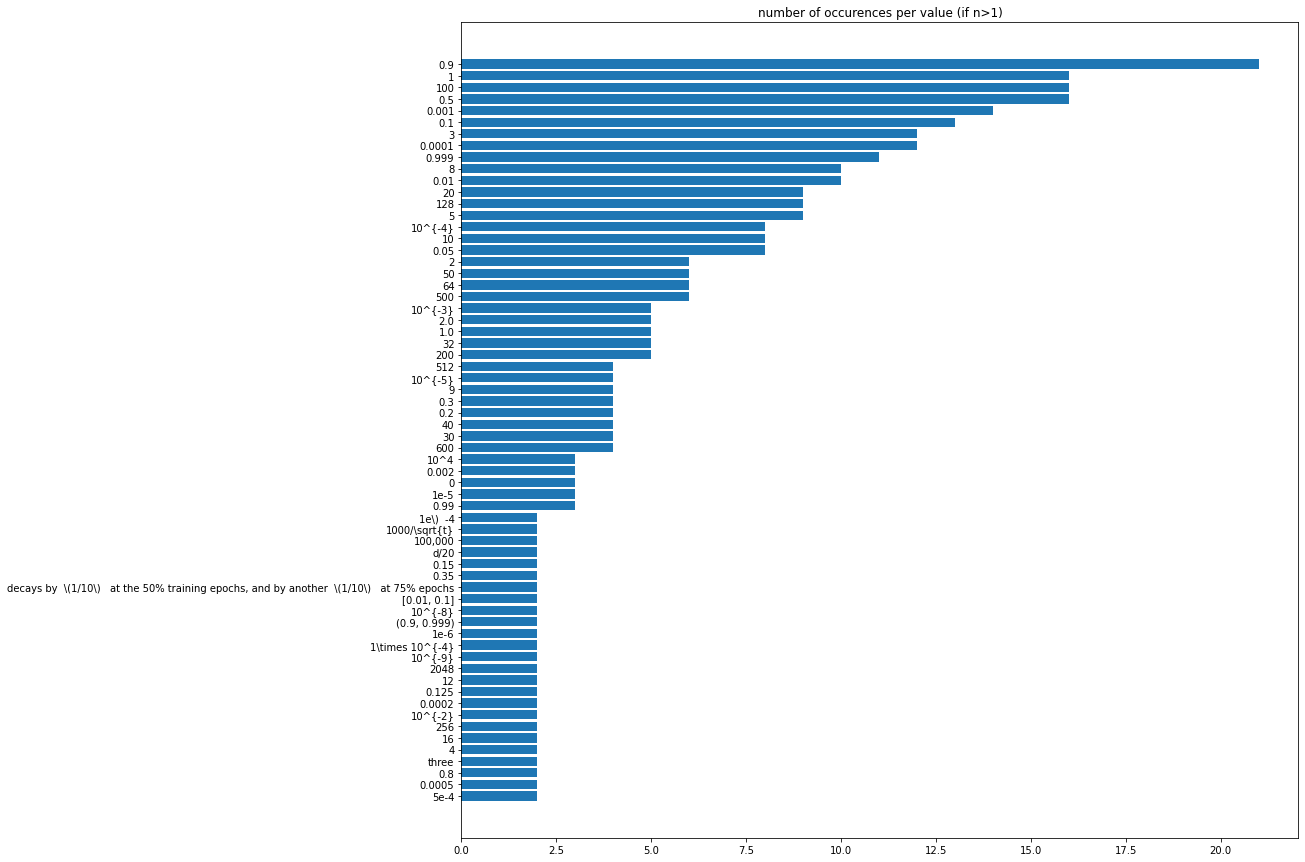

In [9]:
vcounts = sorted(entity_counts_total['v'].items(), key=operator.itemgetter(1))
fig, ax = plt.subplots(figsize=(15,15))
ax.barh(
    [e[0] for e in vcounts if e[1] > 1],
    [e[1] for e in vcounts if e[1] > 1]
)
ax.set_title('number of occurences per value (if n>1)')
plt.savefig(
    os.path.join(fig_path, 'stats_value_counts.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

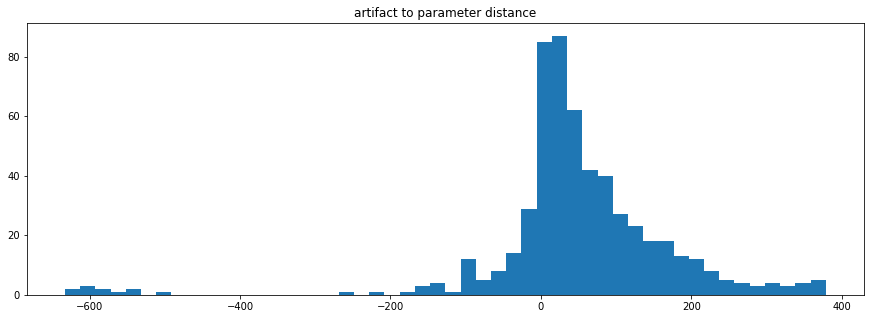

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(annotation_dists['ap'], bins=50)
ax.set_title('artifact to parameter distance')
plt.savefig(
    os.path.join(fig_path, 'stats_artifact_param_distance.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

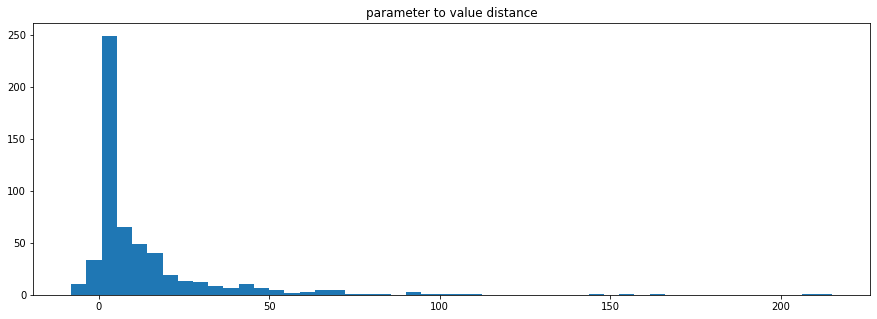

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(annotation_dists['pv'], bins=50)
ax.set_title('parameter to value distance')
plt.savefig(
    os.path.join(fig_path, 'stats_param_value_distance.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

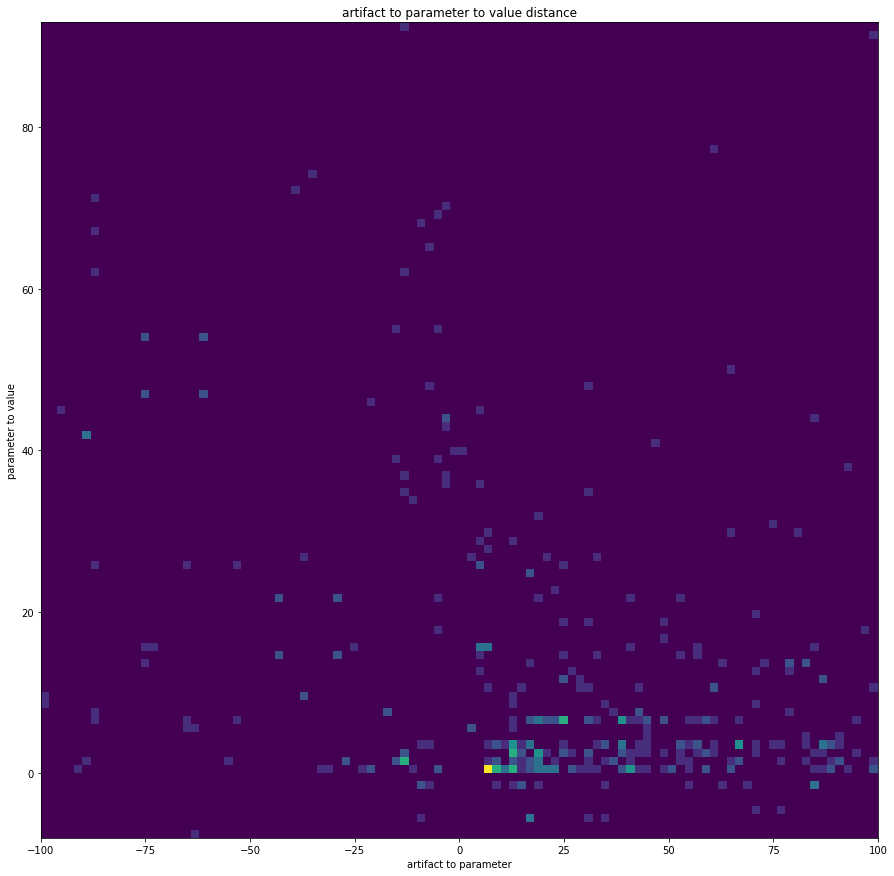

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
lim = 100
ax.hist2d(
    [d[0] for d in annotation_dists['apv'] if abs(d[0])<=lim and abs(d[1])<=lim],
    [d[1] for d in annotation_dists['apv'] if abs(d[0])<=lim and abs(d[1])<=lim],
    bins=lim)
ax.set_title('artifact to parameter to value distance')
ax.set_xlabel('artifact to parameter')
ax.set_ylabel('parameter to value')
plt.savefig(
    os.path.join(fig_path, 'stats_artifact_param_value_distance.pdf'),
    dpi=300,
    format='pdf'
)
plt.show()

In [13]:
# determine “trivial” text segments where there’s only a single connected set of artifact, parameter, and value
# and no other annotations
num_triv = 0
num_non__triv = 0
for txt_seg in text_segments:
    if len(txt_seg['annotation']['entity_dict']) == 3 and len(txt_seg['annotation']['relation_tuples']) == 2:
        num_triv += 1
    else:
        num_non__triv += 1
        
print('{} trivial cases'.format(num_triv))
print('{} non-trivial cases'.format(num_non__triv))

23 trivial cases
128 non-trivial cases


In [14]:
# get number of annotation
print('{} relations'.format(
    len(annotation_dists['ap']) +
    len(annotation_dists['pv'])
))
print('{} annots'.format(
    sum(entity_counts_total['a'].values()) +
    sum(entity_counts_total['p'].values()) +
    sum(entity_counts_total['v'].values())
))

print('{} a<-p<-v triples'.format(len(annotation_dists['apv'])))
print('{} a<-p tuples'.format(len(annotation_dists['ap'])))
print('{} p<-v tuples'.format(len(annotation_dists['pv'])))

print('{} a annots'.format(sum(entity_counts_total['a'].values())))
print('{} p annots'.format(sum(entity_counts_total['p'].values())))
print('{} v annots'.format(sum(entity_counts_total['v'].values())))

1110 relations
1345 annots
587 a<-p<-v triples
553 a<-p tuples
557 p<-v tuples
302 a annots
548 p annots
495 v annots


In [15]:
# get types of values
vcounts = sorted(entity_counts_total['v'].items(), key=operator.itemgetter(1), reverse=True)
basic_number_patt = re.compile(
    r'^-?\s*'
    r'(\d{1,3}(,\d{3})*|\d+)?'
    r'(\.\d+)?$'
)
plain_e_notation_patt = re.compile(
    r'^-?\d+\s*'
    r'e\s*'
    r'-?\d+$'
)
plain_fraction_patt = re.compile(r'^-?\d+/-?\d+$')
latex_power_patt = re.compile(
    r'^-?'
    r'\d+(\.\d+)?'
    r'e?\^'
    r'{?-?\d+}?$'
)
plain_range_patt = re.compile(
    r'^[\[\{(]\s*'
    r'-?\s*'
    r'(\d{1,3}(,\d{3})*|\d+)?'
    r'(\.\d+)?'
    r'\s*,\s*'
    r'-?\s*'
    r'(\d{1,3}(,\d{3})*|\d+)?'
    r'(\.\d+)?'
    r'\s*[\]\})]$'
)
latex_keyword_patt = re.compile(r'\\[a-z]+')
for v, count in vcounts:
    if not basic_number_patt.match(v) and \
            not plain_e_notation_patt.match(v) and \
            not plain_fraction_patt.match(v) and \
            not latex_power_patt.match(v) and \
            not plain_range_patt.match(v):
#             not plain_power_patt.match(v) and \
        print(v)
#     if latex_keyword_patt.search(v):
#         print(latex_keyword_patt.findall(v))

three
1\times 10^{-4}
decays by  \(1/10\)   at the 50% training epochs, and by another  \(1/10\)   at 75% epochs
d/20
1000/\sqrt{t}
1e\)  -4
4 pixels on each side
probability  \(0.5
32\times 32\)   window
30K
\sigma _2
every 10 epochs
starts from  \(0.5\)   and reduces by  \(5\%\)   per iteration until  \(0.1
lbrace \)  1/8, 1/4, 1/2, 1, 2, 4, 8 \(\rbrace
\lbrace \)  1/2, 1, 2 \(\rbrace
10^{-5}/5 \times 10^{-5}
0.0003\)   with a decay factor  \(0.1\)   at every 40 epochs
1 \times 10^{-3}
1.6\)  M
between  \(-15\)   and 15 pixels
between  \(-25\)   and 25 degrees
double
warms up to  \(10^{-3}\)   in the first 10k steps and then decays with the inverse square root schedule
256  \(\times \)   256
gray images
300-700
5 \cdot 10^{-4}
0.01 and is divided by 10 at the 100th epoch and the 160th epoch
0.01 and is divided by 10 at the 200th epoch and the 370th epoch
weight decay
0.005 and is divided by 5 at the 150th epoch, then divided by 2 at the 450th epoch
mini-batch size
5e-8 and is multipl